# Nonlinearities

In [103]:
import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import make_moons, make_blobs
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn
from torchsummary import summary

(800, 2) (200, 2) (800,) (200,)


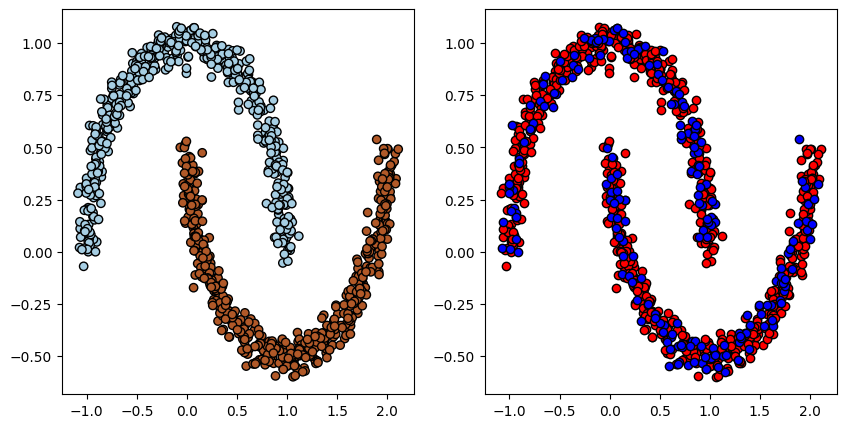

In [104]:
# Configuration options
num_classes = 2
X, y = make_moons(n_samples= 1000 , noise=0.05)
# X, y = make_blobs(n_samples=1000, n_features = 2, centers=num_classes, random_state=1)

X_train, X_test, y_train, y_test = train_test_split( X , y , test_size = 0.20, random_state = 1)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

_, axes = plt.subplots (1,2, figsize=(10,5))

axes[0].scatter( X[:, 0] , X[:, 1] , c = y , cmap='Paired', edgecolors='k')
axes[1].scatter( X_train[:, 0] , X_train[:, 1] , c="r", edgecolors='k')
axes[1].scatter( X_test [:, 0] , X_test [:, 1] , c="b", edgecolors='k')

In [ ]:
# # Convert into greyscale
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

In [105]:
# X_train = MinMaxScaler().fit_transform(X_train)
# X_test  = MinMaxScaler().fit_transform(X_test)

print ("Min-Max X_train: [{0:.3f}, {1:.3f}] ".format(X_train.min(), X_train.max()))
print ("Min-Max X_test : [{0:.3f}, {1:.3f}] ".format(X_test.min(), X_test.max()))

Min-Max X_train: [-1.088, 2.111] 
Min-Max X_test : [-1.072, 2.084] 


In [106]:
# Convert target classes to categorical ones
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Set the input shape
input_shape = (X_train.shape)
print(f'Feature shape: {input_shape}')

Feature shape: (800, 2)


In [107]:
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(800, 2) (200, 2) (800, 2) (200, 2)


## Create a graph model

In [271]:
model = nn.Sequential(
    nn.Linear(2, 20), nn.ReLU(),
    nn.Linear(20, 40), nn.ReLU(),
    nn.Linear(40, num_classes), nn.Softmax() #nn.Sigmoid() #
)

# model.cuda()
summary(model.cuda(), input_size=(2,))
# print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]              60
              ReLU-2                   [-1, 20]               0
            Linear-3                   [-1, 40]             840
              ReLU-4                   [-1, 40]               0
            Linear-5                    [-1, 2]              82
           Softmax-6                    [-1, 2]               0
Total params: 982
Trainable params: 982
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


## Define loss function and optimizer

In [272]:
loss = nn.CrossEntropyLoss() #nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3) # torch.optim.SGD(model.parameters(), lr = 5e-3)

model.cuda()
loss.cuda()

CrossEntropyLoss()

## Train model

In [273]:
epochs = 800
batch_size = 200
losses = []

start_time = time.time()
progress = tqdm(range( epochs ), ncols=110)

for epoch in progress:
  #
  batch_losses = 0

  for batch_i in range(0, len(X_train), batch_size):
    #
    batch_X = X_train[ batch_i : batch_i + batch_size ]
    batch_y = y_train[ batch_i : batch_i + batch_size ]
    batch_X = torch.from_numpy(batch_X).to(torch.float32).cuda()
    batch_y = torch.from_numpy(batch_y).to(torch.float32).cuda()

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    predictions = model( batch_X )

    # Compute loss
    batch_loss = loss( predictions , batch_y )

    # Perform backward pass
    batch_loss.backward()

    # Optimize parameters
    optimizer.step()

    ## Save stats
    batch_losses += batch_loss.item()


  epoch_loss = batch_losses/(len(X_train)/batch_size)
  elapsed_time = time.time() - start_time
  progress.set_description("Epoch [%d/%d] [Loss: %f] time: %3f" % (epoch, epochs,
                                                                   epoch_loss,
                                                                   elapsed_time))

  losses.append(epoch_loss)


Epoch [799/800] [Loss: 0.313298] time: 8.407639: 100%|██████████████████████| 800/800 [00:08<00:00, 95.16it/s]


## Plot results

Text(0.5, 0, 'Epoch')

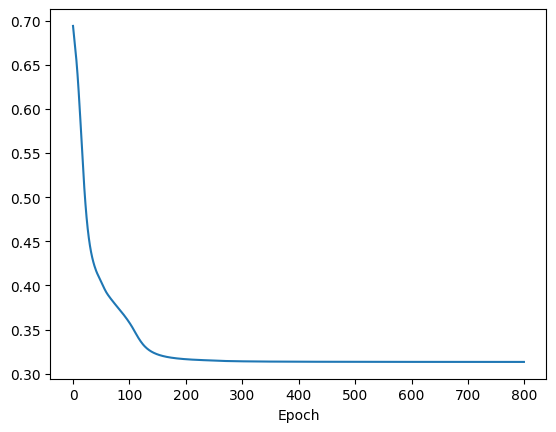

In [274]:
import seaborn as sns

plt.plot(np.array(losses))
plt.xlabel("Epoch")

In [275]:
h_min, h_max = X_test[:, 0].min()-0.1, X_test[:, 0].max()+0.1
v_min, v_max = X_test[:, 1].min()-0.1, X_test[:, 1].max()+0.1

# Crear el grid de las fronteras de decision
h_grid, v_grid = np.meshgrid(np.linspace( h_min , h_max , 1000), np.linspace( v_min , v_max , 1000))

# Predecir los valores del grid
grid_ = torch.from_numpy( np.c_[h_grid.ravel(), v_grid.ravel()] ).to(torch.float32).cuda()
pred_grid = model( grid_ )
pred_grid = np.argmax( pred_grid.detach().cpu().numpy() , axis=1)
print (pred_grid.shape)

# Encajar las predicciones al tamaño del grid
pred_grid = pred_grid.reshape(h_grid.shape)
print (pred_grid.shape, h_grid.shape, v_grid.shape)

(1000000,)
(1000, 1000) (1000, 1000) (1000, 1000)


In [276]:
batch_X = torch.from_numpy( X_test ).to(torch.float32).cuda()
predictions = model(batch_X)
predictions = np.argmax(predictions.detach().cpu().numpy(), axis=1)
batch_y = np.argmax(y_test, axis=1)
print (predictions.shape, batch_y.shape)

(200,) (200,)


[]

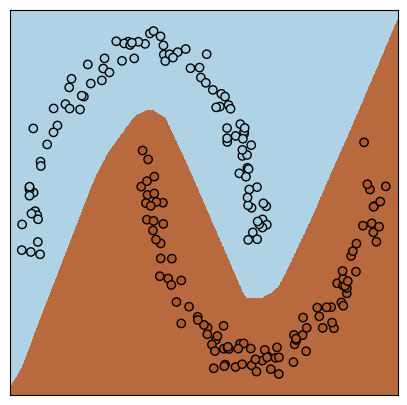

In [277]:
_, ax = plt.subplots (figsize=(5,5))

# Put the result into a color plot
plt.pcolormesh( h_grid , v_grid , pred_grid , cmap=plt.cm.Paired, alpha=0.9)

ax.scatter( X_test[:, 0] ,X_test[:, 1] , c = batch_y , edgecolors='k', cmap=plt.cm.Paired)

# ax.set_xlim(h_grid.min()-.1, h_grid.max()+.1)
# ax.set_ylim(v_grid.min()-.1, v_grid.max()+.1)

ax.set_xticks(())
ax.set_yticks(())